# CCM counter example classification

The following example shows that CCM may not be better than STD

In [21]:
import sys
import numpy as np
from graphviz import Digraph, Source
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sympy import Matrix, simplify, symbols
from sympy.solvers.solveset import linsolve

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.flow import Graph, Node, sample_graph
from lib.models import MLP
from lib.train import train_step_standard, train_step_xyc, train
from lib.regularization import EYE
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap

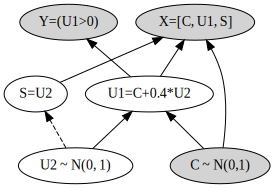

In [2]:
dot = Digraph()

dot.node('X', 'X=[C, U1, S]', style='filled', fillcolor='lightgray')
dot.node('C', 'C ~ N(0,1)', style='filled', fillcolor='lightgray')
dot.node('Y', 'Y=(U1>0)', style='filled', fillcolor='lightgray')
dot.node('U', 'U1=C+0.4*U2')
dot.node('Z', 'U2 ~ N(0, 1)')
dot.node('S', 'S=U2')
dot.edges(['UY', 'CU', 'ZU', 'UX', 'SX', 'CX'])
dot.edge('Z', 'S', style='dashed')

dot.graph_attr['rankdir'] = 'BT'
dot.render('figures/counter_example')
dot

This case is interesting b/c the problem is linear and C for sure is relevant for predicting Y.

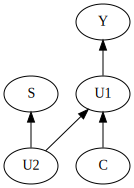

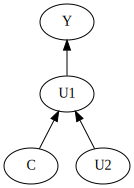

          C        U2         S        U1  Y
0 -0.328478 -0.841422 -0.841422 -0.665047  0
1  1.267562  1.132415  1.132415  1.720528  1
2  1.533854 -0.236301 -0.236301  1.439334  1
3  0.792378  1.696971  1.696971  1.471166  1
4 -0.622260  0.200247  0.200247 -0.542161  0
5 -1.614264 -1.172477 -1.172477 -2.083255  0
6  0.734232  0.294200  0.294200  0.851912  1
7 -0.823884 -1.139418 -1.139418 -1.279651  0
8 -0.656765  2.702627  2.702627  0.424286  1
9 -0.241632  0.412994  0.412994 -0.076434  0


,C,U2,S,U1,Y
0,0.759493,-0.570859,-1.924442,0.531149,1
1,-0.189001,0.100121,-1.135029,-0.148952,0
2,-0.954209,-0.616063,-0.343164,-1.200635,0
3,-0.197812,-0.618013,1.559217,-0.445017,0
4,0.818991,0.311362,0.436508,0.943536,1
5,0.608871,0.748237,-2.523885,0.908166,1
6,0.136659,-1.076185,-0.761160,-0.293815,0
7,0.236512,-0.021207,-0.464127,0.228029,1
8,1.264529,0.881607,0.198293,1.617172,1
9,-0.341486,-1.002171,-1.060884,-0.742355,0


In [3]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    c = Node('C')
    u2 = Node('U2')
    s = Node('S', lambda u2: u2, [u2])
    u1 = Node('U1', lambda c, u2: c + 0.4 * u2, [c, u2])
    y  = Node('Y', lambda u1: (u1 > 0).astype(int),
              [u1], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([c, u1, u2, s, y])   
    return graph

def build_graph_deploy():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    c = Node('C')
    u2 = Node('U2')
    s = Node('S')
    u1 = Node('U1', lambda c, u2: c + 0.4 * u2, [c, u2])
    y  = Node('Y', lambda u1: (u1 > 0).astype(int),
              [u1], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([c, u1, u2, s, y])   
    return graph

graph = build_graph() # the causal graph
graph.draw()
graph_deploy = build_graph_deploy()
graph_deploy.draw()
n = 10
print(sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']])
sample_graph(graph_deploy, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'S': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]

In [4]:
np.sqrt(1.16), 1.4**2

(1.0770329614269007, 1.9599999999999997)

In [17]:
n = 100000
bs = 100

XYC = sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]
XYC_te = sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]
# XYC_deploy = sample_graph(graph_deploy, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'S': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]
XYC_deploy = sample_graph(graph_deploy, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U2', 'S', 'U1', 'Y']]

def get_X_Y_C(XYC):
    X = np.array(XYC[['C', 'U1', 'S']])
    Y = np.array(XYC[['Y']]).ravel()
    C = np.array(XYC[['C']])
    return torch.from_numpy(X).float(), torch.from_numpy(Y).long(), torch.from_numpy(C).float()

X, Y, C = get_X_Y_C(XYC)
d = X.shape[1]
X_te, Y_te, C_te = get_X_Y_C(XYC_te)
X_de, Y_de, C_de = get_X_Y_C(XYC_deploy)

# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
loader_xyc = DataLoader(TensorDataset(X, Y, C), batch_size=bs, shuffle=True) # joint concept and regular dataset

loader_xy_te = DataLoader(TensorDataset(X_te, Y_te), batch_size=bs, shuffle=False) # regular dataset
loader_xyc_te = DataLoader(TensorDataset(X_te, Y_te, C_te), batch_size=bs, shuffle=False) # joint concept and regular dataset

loader_xy_de = DataLoader(TensorDataset(X_de, Y_de), batch_size=bs, shuffle=False) # regular dataset
loader_xyc_de = DataLoader(TensorDataset(X_de, Y_de, C_de), batch_size=bs, shuffle=False) # joint concept and regular dataset

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 768.44it/s]


epoch   2: loss 9.946e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 745.38it/s]


epoch   5: loss 5.628e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 983.36it/s]


epoch   8: loss 3.822e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 983.57it/s]


epoch  11: loss 2.907e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 986.93it/s]


epoch  14: loss 2.435e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 987.03it/s]


epoch  17: loss 2.248e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 984.07it/s]


epoch  20: loss 2.216e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 990.26it/s]


epoch  23: loss 2.201e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 995.98it/s]


epoch  26: loss 2.194e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 983.83it/s]


epoch  29: loss 2.186e-02


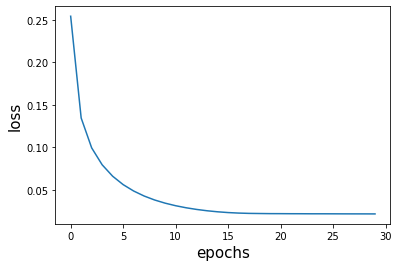

In [6]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True):
    # regular model
    net = MLP([d, 2])
    
    # train
    opt = optim.Adam(net.parameters(), weight_decay=1e-4)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 30
STD = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=n_epochs//10)

In [7]:
# ['C', 'U1=C+0.4*U2', 'S=U2']
STD.classifier[0].weight[1] - STD.classifier[0].weight[0]

tensor([11.5023, 16.0149,  4.5880], grad_fn=<SubBackward0>)

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 769.70it/s]


epoch   2: loss 1.490e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 767.88it/s]


epoch   5: loss 9.655e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 768.22it/s]


epoch   8: loss 8.167e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 770.01it/s]


epoch  11: loss 7.668e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 767.82it/s]


epoch  14: loss 7.210e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 765.35it/s]


epoch  17: loss 6.726e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 760.14it/s]


epoch  20: loss 6.363e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 769.62it/s]


epoch  23: loss 6.204e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 771.01it/s]


epoch  26: loss 6.125e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 765.56it/s]


epoch  29: loss 6.082e-02


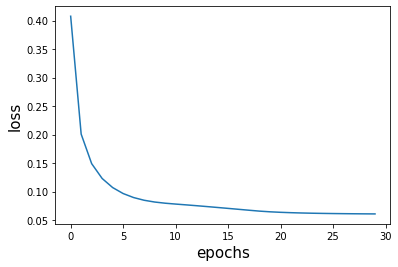

In [13]:
def CCM(loader_xy, d, n_epochs=10, report_every=1, plot=True):
    # regular model
    net = MLP([d, 2])

    # train
    # criterion = lambda o_y, y: F.cross_entropy(o_y, y) + 0.01 * (net.classifier[0].weight[1] - net.classifier[0].weight[0])[1:].abs().sum()
    r = torch.zeros(d)
    r[0] = 1
    criterion = lambda o_y, y: F.cross_entropy(o_y, y) + 0.0009 * EYE(r, (net.classifier[0].weight[1] - net.classifier[0].weight[0])[1:].abs().sum())
    # opt = optim.SGD(net.parameters(), lr=0.1)
    opt = optim.Adam(net.parameters())
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=criterion)
    if plot: plot_log(log)
    return net

n_epochs = 30
ccm = CCM(loader_xy, d, n_epochs=n_epochs, report_every=n_epochs//10)

In [14]:
# ['C', 'U1=C+0.4*U2', 'S=U2']
ccm.classifier[0].weight[1] - ccm.classifier[0].weight[0]

tensor([ 1.7440e+01, -3.4742e-05,  6.7834e+00], grad_fn=<SubBackward0>)

In [15]:
print('task acc after training: {:.1f}%'.format(test(ccm, loader_xy, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(STD, loader_xy_te, acc_criterion) * 100))

test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1173.31it/s]


task acc after training: 99.7%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1493.15it/s]

task acc after training: 100.0%


In [18]:
print('task acc after training: {:.1f}%'.format(test(ccm, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(STD, loader_xy_de, acc_criterion) * 100))

test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 975.43it/s]


task acc after training: 87.8%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1299.69it/s]

task acc after training: 95.1%


# Regression

$$min_\theta \mathbb{E}_{(x=[c,u_1,s,1], y)} (y-\theta^T x)^2 + \lambda ||\theta||_2^2$$ 

where $u_1 = c + a s$ with $a \in \mathbb{R}$.

taking derivative on both sides and set to $0$ simplies to 

In [44]:
# unregularized solution
c, c2, s, s2, a = symbols('E(C) E(C^2) E(S) E(S^2) a')
u1 = c + a * s
y = u1
l = 0

A = Matrix([[c2 + l, c2 + a*c*s, c*s, c], [c2 + a*c*s, c2 + a*a*s2 + 2*a*c*s + l, c*s + a*s2, u1], [s*c, c*s + a*s2, s2 + l, s], [c, u1, s, 1 + l]])
b = Matrix([[c2 + a*c*s], [c2 + a*a*s2 + 2*a*c*s + l], [c*s + a*s2], [y]])

result = linsolve((A, b))
result # [C, U1, S, 1]

FiniteSet((tau0/a, 1 - tau0/a, tau0, 0))

In [45]:
# regularized solution
c, c2, s, s2, a, l = symbols('E(C) E(C^2) E(S) E(S^2) a \lambda')
u1 = c + a * s
y = u1

A = Matrix([[c2 + l, c2 + a*c*s, c*s, c], [c2 + a*c*s, c2 + a*a*s2 + 2*a*c*s + l, c*s + a*s2, u1], [s*c, c*s + a*s2, s2 + l, s], [c, u1, s, 1 + l]])
b = Matrix([[c2 + a*c*s], [c2 + a*a*s2 + 2*a*c*s + l], [c*s + a*s2], [y]])

result = linsolve((A, b))
result # [C, U1, S, 1]

FiniteSet((0, 1, 0, 0))

In [46]:
A

Matrix([
[    E(C^2) + \lambda,                           E(C)*E(S)*a + E(C^2),            E(C)*E(S),          E(C)],
[E(C)*E(S)*a + E(C^2), 2*E(C)*E(S)*a + E(C^2) + E(S^2)*a**2 + \lambda, E(C)*E(S) + E(S^2)*a, E(C) + E(S)*a],
[           E(C)*E(S),                           E(C)*E(S) + E(S^2)*a,     E(S^2) + \lambda,          E(S)],
[                E(C),                                  E(C) + E(S)*a,                 E(S),   \lambda + 1]])